In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import WeightedRandomSampler
from typing import Union, Tuple
import numpy as np
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from tqdm import tqdm
import cv2
import os
import timm
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from einops.layers.torch import Rearrange

/opt/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor

class HardDistillationLoss(nn.Module):
    def __init__(self, teacher: nn.Module):
        super().__init__()
        self.teacher = teacher
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs: Tensor, outputs: tuple[Tensor, Tensor], labels: Tensor) -> Tensor:
        outputs_cls, outputs_dist = outputs

        # Базовая потеря (CLS)
        base_loss = self.criterion(outputs_cls, labels)

        # Вычисляем предсказания учителя
        with torch.no_grad():
            teacher_outputs = self.teacher(inputs)

        # Ограничиваем выходы учителя двумя классами
        teacher_logits = teacher_outputs[:, :2]  # Берем только первые два класса
        teacher_labels = torch.argmax(teacher_logits, dim=1)

        # Потеря для DIST
        teacher_loss = self.criterion(outputs_dist, teacher_labels)

        # Комбинируем потери
        return 0.5 * base_loss + 0.5 * teacher_loss

In [3]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 384, img_size: int = 224):
        super().__init__()
        self.patch_size = patch_size

        # Проекция патчей
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

        # Токены CLS и DIST
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.dist_token = nn.Parameter(torch.randn(1, 1, emb_size))  # Убедитесь, что это определено

        # Позиционные эмбеддинги
        num_patches = (img_size // patch_size) ** 2
        self.positions = nn.Parameter(torch.randn(num_patches + 2, emb_size))  # +2 для cls_token и dist_token

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        # Проекция патчей
        x = self.projection(x)

        # Создание токенов CLS и DIST
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        dist_tokens = repeat(self.dist_token, '() n e -> b n e', b=b)

        # Добавление токенов CLS и DIST к входным данным
        x = torch.cat([cls_tokens, dist_tokens, x], dim=1)

        # Добавление позиционных эмбеддингов
        x += self.positions

        return x

In [5]:
class DeiT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 384,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 2,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes))

In [75]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Определение преобразований для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),  # Преобразует в 3 канала
    transforms.ToTensor(),                         # В тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Подходит для grayscale
])

# Создание датасета с помощью ImageFolder
ds = datasets.ImageFolder(root='/Users/ilia/brainTumorClassification/archive-3/Brain Tumor Data Set/Brain Tumor Data Set/', transform=transform)

# Создание DataLoader
dl = DataLoader(ds, batch_size=32, shuffle=False)

print(ds.classes)  # ['tumor', 'no_tumor', 'anomaly']
print(len(ds))

['Brain Tumor', 'Healthy']
4294


In [76]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook для сохранения градиентов и активаций
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x, class_idx=None):
        # Сохраняем исходные размеры изображения
        original_size = x.shape[-2:]  # (height, width)
        h, w = original_size
        print('h: ', h, 'w: ', w)
    
        # Проверка, что размеры корректны
        if h <= 0 or w <= 0:
            raise ValueError(f"Некорректные размеры изображения: height={h}, width={w}")
    
        # Прямой проход через модель
        logits = self.model(x)
        if isinstance(logits, tuple):
            logits = logits[0]  # Берём первый выход (CLS)
        self.model.zero_grad()
    
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
    
        one_hot = torch.zeros_like(logits)
        one_hot[0][class_idx] = 1
        one_hot.requires_grad_(True)
        
        # Вычисляем градиенты относительно one_hot
        output = (one_hot * logits).sum()
        output.backward(retain_graph=True)
    
        gradients = self.gradients.cpu().numpy()[0]
        activations = self.activations.cpu().numpy()[0]
    
        weights = np.mean(gradients, axis=(1, 2))
        print('h: ', h, 'w: ', w)
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
    
        for i, w in enumerate(weights):
            w=224
            cam += w * activations[i]
            # print('activations[i]: ',activations[i])
    
        cam = np.maximum(cam, 0)
        print('h: ', h, 'w: ', w)
    
        # Проверка размеров перед изменением размера
        if int(w) <= 0 or int(h) <= 0:
            raise ValueError(f"Некорректные размеры для изменения размера: w={w}, h={h}")
        # w=224    
        cam = cv2.resize(cam, (int(w), int(h)))  # Преобразуем w и h в целые числа
        
    
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

    def __call__(self, x, class_idx=None):
        return self.forward(x, class_idx)

In [77]:
# подготовка данных и моделей
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),  # Преобразует в 3 канала
    transforms.ToTensor(),                         # В тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Подходит для grayscale
])

ds = datasets.ImageFolder(root='/Users/ilia/brainTumorClassification/archive-3/Brain Tumor Data Set/Brain Tumor Data Set/', transform=transform)
dl = DataLoader(ds, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=2)
student = DeiT(n_classes=2)

optimizer = optim.Adam(student.parameters(), lr=0.001)
criterion = HardDistillationLoss(teacher)

teacher.to(device)
student.to(device)

train_losses = []
train_accuracies = []
train_f1_scores = []
train_auc_scores = []

try:
    for epoch in range(5):
        student.train()
        running_loss = 0.0
        all_labels, all_preds, all_probs = [], [], []

        for batch in tqdm(dl, desc=f"Epoch {epoch+1}/5"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = student(inputs)
            if isinstance(outputs, tuple):
                outputs_cls, outputs_dist = outputs
            else:
                outputs_cls = outputs
                outputs_dist = outputs
            loss = criterion(inputs, (outputs_cls, outputs_dist), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            probs = torch.softmax(outputs_cls, dim=1).detach().cpu().numpy()
            preds = probs.argmax(axis=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs[:, 1])

        epoch_loss = running_loss / len(dl)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds)
        epoch_auc = roc_auc_score(all_labels, all_probs)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_f1_scores.append(epoch_f1)
        train_auc_scores.append(epoch_auc)

        print(f"Epoch {epoch+1}/5 | Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, AUC: {epoch_auc:.4f}")

except Exception as e:
    print("Ошибка:", e)

Epoch 1/5: 100%|██████████████████████████████| 537/537 [27:15<00:00,  3.05s/it]


Epoch 1/5 | Loss: 0.5549, Acc: 0.7247, F1: 0.5291, AUC: 0.7564


Epoch 2/5: 100%|██████████████████████████████| 537/537 [26:27<00:00,  2.96s/it]


Epoch 2/5 | Loss: 0.4720, Acc: 0.7359, F1: 0.5424, AUC: 0.7796


Epoch 3/5: 100%|██████████████████████████████| 537/537 [26:41<00:00,  2.98s/it]


Epoch 3/5 | Loss: 0.5034, Acc: 0.7324, F1: 0.5324, AUC: 0.7620


Epoch 4/5: 100%|██████████████████████████████| 537/537 [25:57<00:00,  2.90s/it]


Epoch 4/5 | Loss: 0.5252, Acc: 0.7299, F1: 0.5238, AUC: 0.7327


Epoch 5/5: 100%|██████████████████████████████| 537/537 [26:25<00:00,  2.95s/it]

Epoch 5/5 | Loss: 0.4705, Acc: 0.7483, F1: 0.5310, AUC: 0.7411


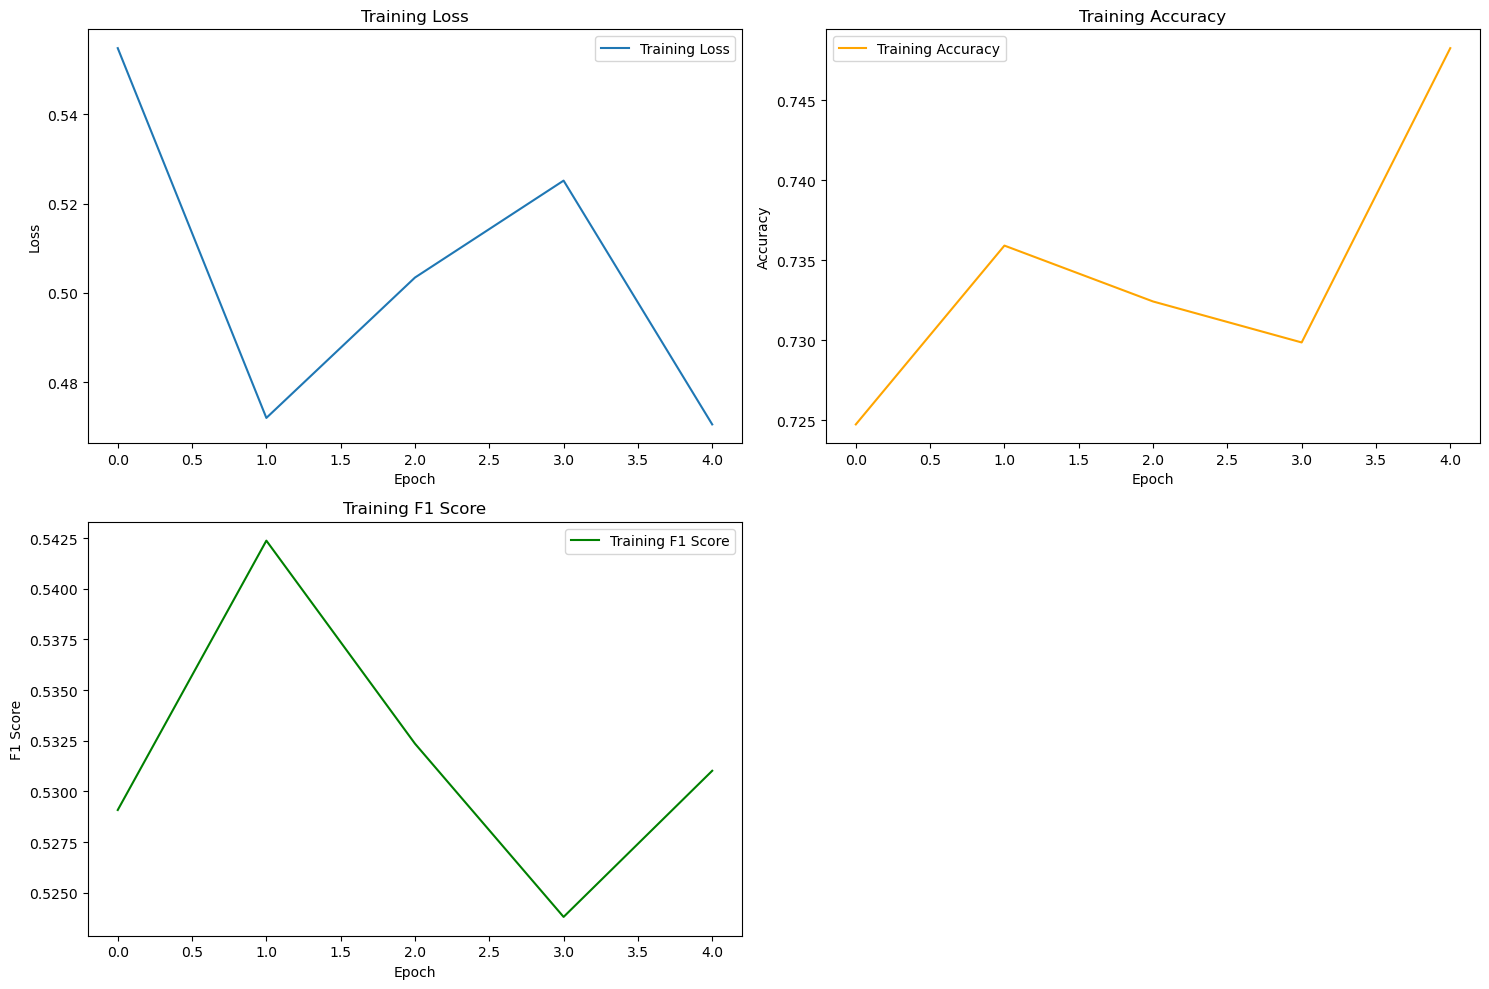

In [78]:
import matplotlib.pyplot as plt

# Преобразование списков метрик в массивы NumPy
loss = [l.detach().cpu().item() if isinstance(l, torch.Tensor) else l for l in train_losses]
train_accuracies = [acc.detach().cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies]
train_f1_scores = [f1.detach().cpu().item() if isinstance(f1, torch.Tensor) else f1 for f1 in train_f1_scores]
train_auc_scores = [auc.detach().cpu().item() if isinstance(auc, torch.Tensor) else auc for auc in train_auc_scores]

# Построение графиков
plt.figure(figsize=(15, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# График F1-меры
plt.subplot(2, 2, 3)
plt.plot(train_f1_scores, label='Training F1 Score', color='green')
plt.title('Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# График AUC-ROC
# plt.subplot(2, 2, 4)
# plt.plot(train_auc_scores, label='Training AUC-ROC', color='red')
# plt.title('Training AUC-ROC')
# plt.xlabel('Epoch')
# plt.ylabel('AUC-ROC')
# plt.legend()

plt.tight_layout()
plt.show()

h:  224 w:  224


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


h:  224 w:  224
h:  224 w:  224


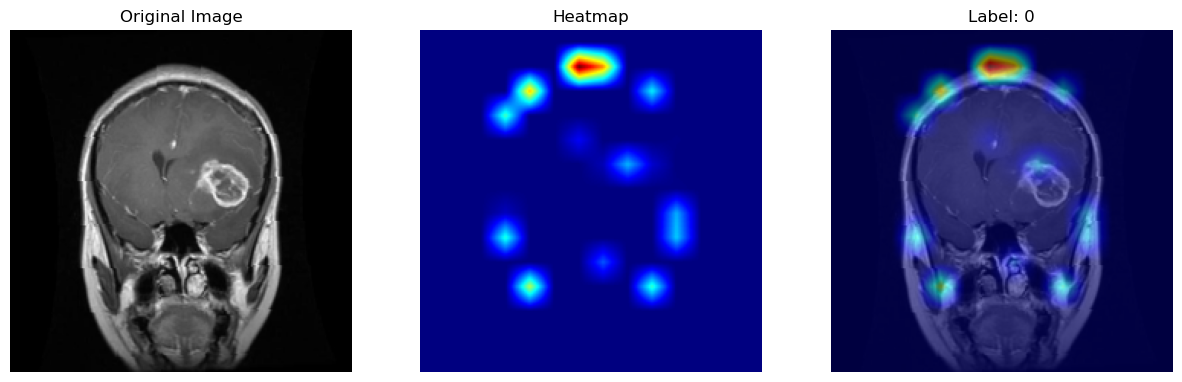

h:  224 w:  224
h:  224 w:  224
h:  224 w:  224


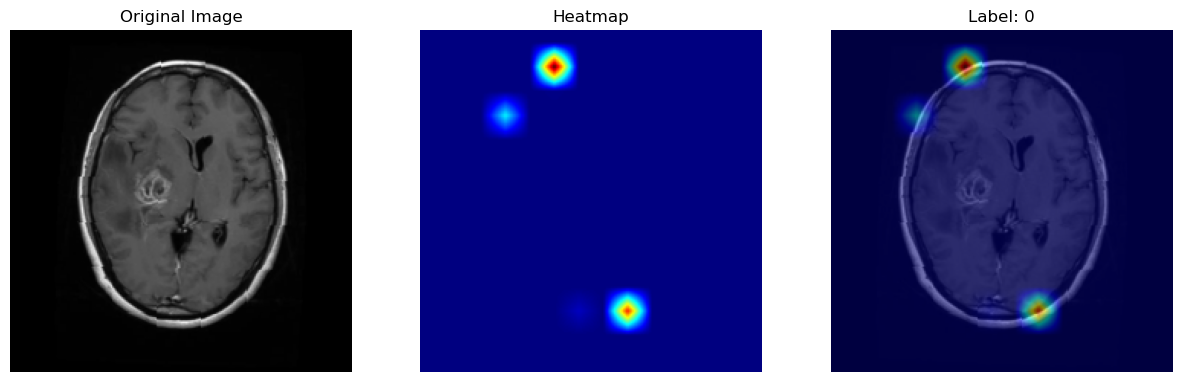

h:  224 w:  224
h:  224 w:  224
h:  224 w:  224


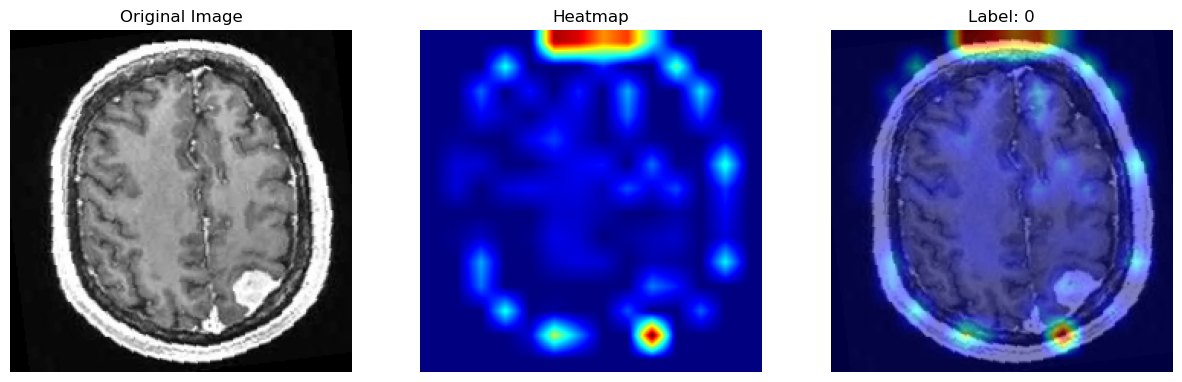

h:  224 w:  224
h:  224 w:  224
h:  224 w:  224


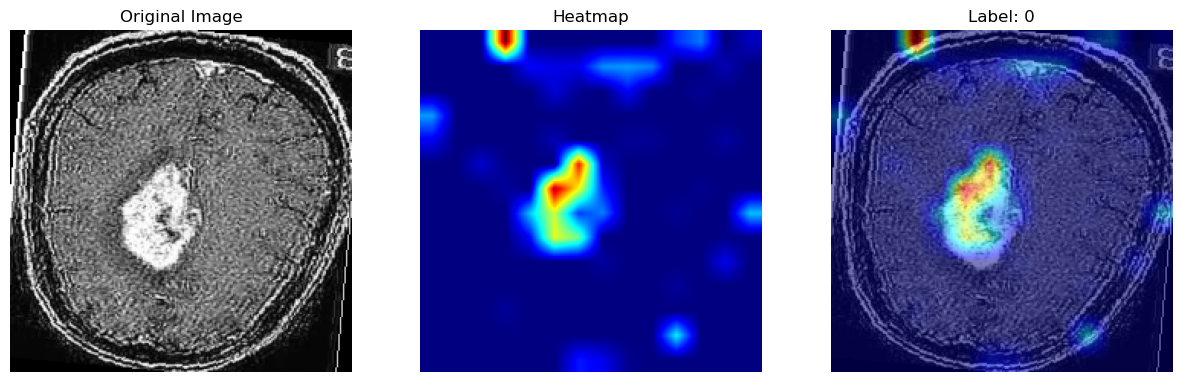

h:  224 w:  224
h:  224 w:  224
h:  224 w:  224


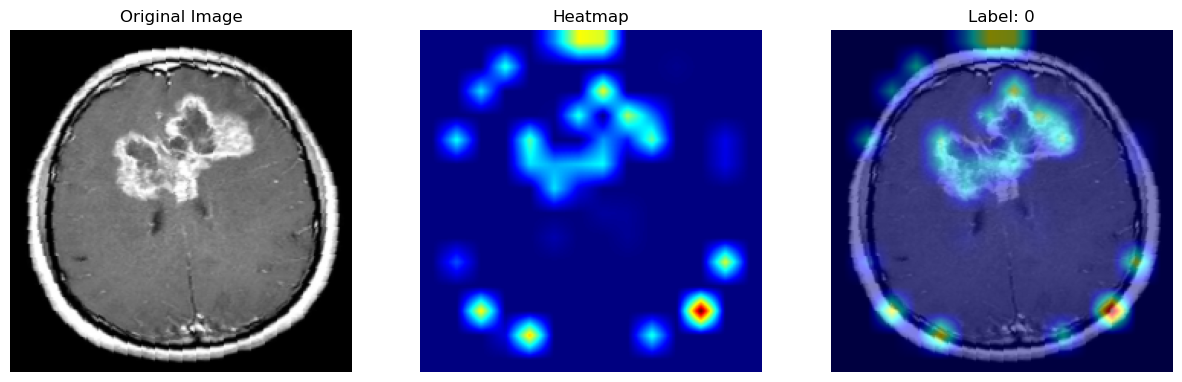

In [79]:
import numpy as np
import cv2
def visualize_cam(image, cam, title="Grad-CAM"):
    """Отображение исходного изображения и тепловой карты."""
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap.astype(np.float32) / 255
    overlay = image + heatmap
    overlay = overlay / overlay.max()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(heatmap)
    ax[1].set_title("Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay)
    ax[2].set_title(title)
    ax[2].axis("off")
    plt.show()

#случайные изображения из тестового датасета
student.eval()
with torch.no_grad():
    sample_images = []
    sample_labels = []
    for i in range(5):  #5 случайных изображений
        idx = np.random.randint(len(ds))
        img, label = ds[idx]
        sample_images.append(img)
        sample_labels.append(label)

# Grad-CAM к выбранным изображениям
target_layer = student[0].projection[0]  # Целевой слой для Grad-CAM
grad_cam = GradCAM(student, target_layer)

for img, label in zip(sample_images, sample_labels):
    img = img.unsqueeze(0).to(device)
    cam = grad_cam(img)
    visualize_cam(img.squeeze(0), cam, title=f"Label: {label}")

In [80]:
# После обучения
torch.save(student.state_dict(), 'deit_binary_model.pth')
print("Модель сохранена как deit_binary_model.pth")

Модель сохранена как deit_binary_model.pth


In [81]:
# Сохранение модели
model_save_path = "DeiT_binary.pth"  # Укажите путь и имя файла

torch.save(student, "DeiT_binary.pth")

print(f"Модель успешно сохранена в файл: {model_save_path}")

Модель успешно сохранена в файл: DeiT_binary.pth


In [93]:
import torch
from torchvision import transforms
from PIL import Image

# 1. Импортируй класс DeiT, если он не в этом же файле
# from saving import DeiT

# 2. Создай экземпляр модели с теми же параметрами, что и при обучении
model = DeiT(
    in_channels=3,
    patch_size=16,
    emb_size=384,
    img_size=224,
    depth=12,
    n_classes=2
)

# 3. Загрузи веса
model.load_state_dict(torch.load('deit_binary_model.pth', map_location='cpu'))
model.eval()

# 4. Преобразования (должны совпадать с обучением!)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # если было при обучении!
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 5. Классы (два класса, порядок как в обучении)
class_names = ['tumor', 'no_tumor']

# 6. Функция предсказания с мета-моделью
def predict_with_anomaly_check(model, image_tensor, class_names, threshold=0.7):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        if isinstance(output, tuple):
            output = output[0]  # Берём CLS-токен
        probs = torch.softmax(output, dim=1)
        max_prob, pred_idx = probs.max(dim=1)
    predicted_class = class_names[pred_idx.item()]
    confidence = max_prob.item()
    if confidence < threshold:
        return "аномальное", confidence
    else:
        return predicted_class, confidence

# 7. Загрузка изображения
image_path = '/Users/ilia/brainTumorClassification/archive-3/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1427).jpg'
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # batch dimension

# 8. Предсказание
predicted_class, confidence = predict_with_anomaly_check(model, input_tensor, class_names, threshold=0.3)
# print(f"Предсказанный класс: {predicted_class}")
print(f"Уверенность: {confidence:.2f}")
if confidence > 0.7 and < 0.8:
    print('На изображении видная опухоль, пожалуйста, обратитесь к врачу за мдицинской помощьюэ')
if confidence < 0.6:
    print('Выявлена аномалия, данные не точны, пожалуйста, обратитесь к специалисту за дополнительной информацией')

Уверенность: 0.76
